In [1]:
import os
import csv
import shapefile
import pysal
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Set and check the data path

In [3]:
data_dir = os.path.abspath('Data')
geom_file = os.path.join(data_dir, 'NYC_sample_geometries.csv')
flow_file = os.path.join(data_dir, 'NYC_sample_flow.csv')

if os.path.exists(geom_file):
    print('Input file:', geom_file, flow_file)
else:
    print('Data directory is:', data_dir)
    print('Please fix the path!')

('Input file:', "C:\\Users\\Scarlett's Laptop\\Documents\\Git\\Project\\NYC-hexagon-outlier-detection\\Data\\NYC_sample_geometries.csv", "C:\\Users\\Scarlett's Laptop\\Documents\\Git\\Project\\NYC-hexagon-outlier-detection\\Data\\NYC_sample_flow.csv")


# 1. Create the shapefile
reference: http://geospatialpython.com/2015/08/csv-to-shapefile.html

In [4]:
# Create a polygon shapefile writer
wrt = shapefile.Writer(shapefile.POLYGON)

In [5]:
# Add fields
wrt.field('AreaId', 'N', 6, 0)

In [6]:
# Open the csv file and set up a reader
with open(geom_file) as p:
    reader = csv.DictReader(p)
    for row in reader:
        # Add records for each polygon
        wrt.record(row['AreaId'])
        # Parse the coordinate string
        wkt = row['Geometry'][15:-3]
        # Break the coordinate string into x,y coordinates
        coords = wkt.split(",")
        # Set up a list to contain the coordinates for each node
        part = []
        # Convert the x,y values to floats
        for c in coords:
            x,y = c.split(' ')
            part.append([float(x), float(y)])
        # Create a polygon record with the list of coordinates
        wrt.poly(parts=[part])

In [7]:
# Save the shapefile
wrt.save('NYC_sample_hexagons.shp')

# 2. Create the neighbor list
For each AreaId, detect its neighbors, i.e. the polygons that share a common edge. 

In [8]:
nb = pysal.rook_from_shapefile('NYC_sample_hexagons.shp', 'AreaId')

In [9]:
nb.neighbors

{235205: [235391, 235392, 235204, 235206, 235019, 235020],
 232206: [232392, 232393, 232020, 232021, 232205, 232207],
 233131: [233316, 233317, 232944, 232945, 233130, 233132],
 232790: [232789, 232791, 232975, 232976, 232603, 232604],
 234252: [234065, 234066, 234251, 234253],
 233132: [233133, 233317, 233318, 232945, 232946, 233131],
 232791: [232790, 232792, 232976, 232977, 232604, 232605],
 233881: [234066, 234067, 233694, 233695, 233880, 233882],
 235207: [235022, 235393, 235394, 235206, 235208, 235021],
 233133: [233134, 233318, 233319, 232946, 232947, 233132],
 232792: [232791, 232793, 232977, 232978, 232605, 232606],
 233726: [233541, 233725, 233727, 233912, 233913, 233540],
 233134: [233133, 233135, 233319, 233320, 232947, 232948],
 232982: [233168, 233169, 232796, 232797, 232981, 232983],
 232793: [232792, 232794, 232978, 232979, 232606, 232607],
 233497: [233683, 233498, 233311],
 233498: [233683, 233684, 233311, 233312, 233497, 233499],
 231451: [231637, 231638, 231452, 231

In [10]:
hist = pd.DataFrame(nb.histogram, columns=['bin', 'cnt'])

<Container object of 5 artists>

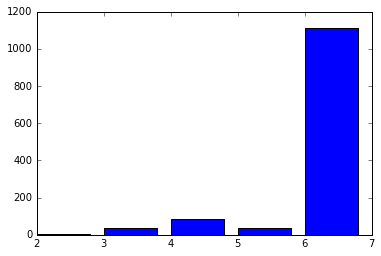

In [11]:
plt.bar(hist.bin,hist.cnt)

# 3. Final output 

In [12]:
# Read in nyc_flow.csv and pivot the table
flow = pd.read_csv(flow_file)

In [13]:
areaIds = list(set(flow.AreaId)) # iterate through a list is faster than through a set

In [14]:
flow = flow.set_index(['AreaId', 'StartTime'])

In [15]:
flow.head()

NewCount
AreaId StartTime                    
229777 2015-09-01 00:00:00       304
       2015-09-01 01:00:00       100
       2015-09-01 02:00:00        52
       2015-09-01 03:00:00       304
       2015-09-01 04:00:00       248

In [16]:
all_neighbors_mean_counts = pd.DataFrame()
for areaId in areaIds:
    neighbors = set(nb.neighbors[areaId])
    neighbors_df = flow[flow.index.isin(neighbors, level='AreaId')]
    neighbors_mean_count = neighbors_df.mean(level='StartTime').reset_index()
    neighbors_mean_count['AreaId'] = areaId
    all_neighbors_mean_counts = all_neighbors_mean_counts.append(neighbors_mean_count)

In [17]:
all_neighbors_mean_counts.rename(columns={'NewCount':'Average'}, inplace=True)

In [18]:
all_neighbors_mean_counts = all_neighbors_mean_counts.set_index(['AreaId', 'StartTime'])


In [19]:
count_difference = flow.join(all_neighbors_mean_counts)
count_difference['Diff'] = count_difference.NewCount - count_difference.Average 

In [20]:
count_difference.head()

NewCount  Average   Diff
AreaId StartTime                                    
229777 2015-09-01 00:00:00       304    252.5   51.5
       2015-09-01 01:00:00       100    393.5 -293.5
       2015-09-01 02:00:00        52     44.0    8.0
       2015-09-01 03:00:00       304    165.5  138.5
       2015-09-01 04:00:00       248    346.5  -98.5

In [21]:
count_difference.to_csv('NYC_sample_difference.csv')

# 4. Some visualization